# Big Data Analytics Project: Medical Appointment No Shows

In [3]:
!pip install jovian --upgrade --quiet

In [4]:
import jovian

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Table of Contents

1. [Data Preparation](#dp) 
2. [Dummy Classifier](#dummy)
3. [Model Selection and Assestment](#model_sel_ass)
4. [Testing different balancing techniques](#balancing)
5. [Conclusions](#conclusions)
6. [Example of Classification](#example)

First of all, we install a useful library for unbalanced learning.

In [6]:
!pip install -U imbalanced-learn

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd 
import scipy as sp
import sklearn as sk
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from collections import defaultdict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from numpy import save, load
from sklearn.metrics import roc_curve, auc
import pickle
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [8]:
sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize

<a id='dp'></a>

# Data Preparation

The dataset can be downloaded [here](https://drive.google.com/file/d/1pckE1kPRKGiYk2E_V71HJd6Ux0FQYH3w/view?usp=sharing).

In [9]:
df = pd.read_csv("/content/drive/MyDrive/BigData/NoShowAppointments-part2.csv")
df.head(3)

,PatientID,AppointmentID,Gender,ScheduledDate,AppointmentDate,Age,Neighbourhood,FinancialAid,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AppointmentDay,WaitingDays,WaitingTime,AgeGroup,HasHandicap,PrevAppointments,PrevNoShowRatio
0,39217.84439,5751990,F,2016-05-31,2016-06-03,44,PRAIA DO SUÁ,0,0,0,0,0,0,0,Friday,3,Short,Adult,0,0,0.0
1,43741.75652,5760144,M,2016-06-01,2016-06-01,39,MARIA ORTIZ,0,0,1,0,0,0,0,Wednesday,0,Same Day,Adult,0,0,0.0
2,93779.52927,5712759,F,2016-05-18,2016-05-18,33,CENTRO,0,0,0,0,0,0,0,Wednesday,0,Same Day,Adult,0,0,0.0


We delete some features that we think are not significant for the classification task: *PatientID*, *AppointmentID*, *ScheduledDate* and *AppointmentDate*. 

We also delete the features that we obtained by categorizing other features: *WaitingTime*, *AgeGroup* and *Handicap*. These features were created to better visualize the dataset composition in the data understanding phase.

In [10]:
df.drop(['PatientID', 'AppointmentID', 'ScheduledDate', 'AppointmentDate', 'WaitingTime', 'AgeGroup', 'HasHandicap'], inplace=True, axis=1)

We encode the categorical features.

In [11]:
enc = OrdinalEncoder()
df[['GenderCoded', 'NeighbourhoodCoded', 'AppointmentDayCoded']] = enc.fit_transform(df[['Gender', 'Neighbourhood', 'AppointmentDay']])
df.drop(['Gender', 'Neighbourhood', 'AppointmentDay'], inplace=True, axis=1)

We separate the target variable from the rest of the dataset.

Then, we split the dataset into training set (67 \% of the records) and test set (33 \% of the records). We decided to use a stratified splitting strategy to mantain the proportion of the two classes in the original dataset.

In [12]:
y = df['No_show']
X = df.drop('No_show', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


We define the following helping function to print the classification results.

In [13]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['Show', 'No_show']), end="\n")

For each classifier, the metrics that we will take into consideration are Recall, Precision and F1-Score. 

In particular we will focus on the Racall of the No-Show class: we would like a model that rarely makes mistakes by predicting the show class for appointments that will eventually be no-shows, since this type of error could lead to a significant waste of resources. On the other hand, it could be acceptable to have a model that misclassifies some show records as no-show and rarely missclassifies no-show records.

<a id='dummy'></a>
# Dummy Classifier

In order to have a baseline to compare against our results, we trained a Dummy Classifier. This model generates predictions by respecting the training set's class distribution.

In [14]:
dummy = DummyClassifier(strategy='stratified')
# Training
dummy = dummy.fit(X_train, y_train)

# Evaluation
train_prediction_dummy = dummy.predict(X_train)
test_prediction_dummy = dummy.predict(X_test)
print("RESULTS ON TRAINING SET:")
report_scores(y_train, train_prediction_dummy)
print("RESULTS ON TEST SET:")
report_scores(y_test, test_prediction_dummy)

RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.80      0.80      0.80     59099
     No_show       0.20      0.20      0.20     14950

    accuracy                           0.68     74049
   macro avg       0.50      0.50      0.50     74049
weighted avg       0.68      0.68      0.68     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.80      0.80      0.80     29108
     No_show       0.21      0.20      0.20      7364

    accuracy                           0.68     36472
   macro avg       0.50      0.50      0.50     36472
weighted avg       0.68      0.68      0.68     36472



As expected, since the dataset is unbalanced the classifier achieves high Precision and Recall on the Show class and it performs poorly on the No-Show class.

<a id='model_sel_ass'></a>
# Model Selection and Assessment

In this section we will test different models on the three following datasets:


1.   Dataset obtained by performing feature selection.
2.   Dataset with only the original features.
3.   Dataset with all the features.

The aims of our approach are:
- To verify whether the features added during the Feature Engineering Phase are useful for the classification task. To investigate this we will compare the results obtained with the original datasets and the one with all the features.

- To identify the more meaningful features on which to train the models.


In the end we will select the best performing model, trained with the best set of features.

## Model Search Space & Hyperparameter Space

We choose the models to train and for each model we define its own hyperparameter space.

In [15]:
models = {
    'DecisionTreeClassifier' : DecisionTreeClassifier,
    'RandomForestClassifier' : RandomForestClassifier,
    'LogisticRegression'     : LogisticRegression,
    'GaussianNB' : GaussianNB,
    'AdaBoostClassifier' : AdaBoostClassifier,
}

need_normalization = {
    'DecisionTreeClassifier' : False,
    'RandomForestClassifier' : False,
    'LogisticRegression'     : True,
    'GaussianNB' : False,
    'AdaBoostClassifier' : False,
}

randomized_search = {
    'DecisionTreeClassifier' : False,
    'RandomForestClassifier' : True,
    'LogisticRegression'     : False,
    'GaussianNB' : False,
    'AdaBoostClassifier' : False,
}

hyperparameters = {
    'DecisionTreeClassifier' : {
        'splitter' : ["best", "random"],
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [2, 4, 8, 16, None],
        'min_samples_split' : [2, 16, 32, 64, 128, 256, 512],
        'min_samples_leaf' :  [1, 2, 16, 32, 64, 128, 256, 512],
        'class_weight' : ['balanced'],
        'random_state' : [42]
    },

    'RandomForestClassifier' : {
        'n_estimators' : [100, 200, 300, 400, 500, 600, 700],
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [2, 4, 8, 16, None], 
        'min_samples_split' : [2, 16, 32, 64, 128, 256, 512], 
        'min_samples_leaf' :  [1, 2, 16, 32, 64, 128, 256, 512],
        'class_weight' : ['balanced'],
        'random_state' : [42]
    },

    'LogisticRegression' : {
        'C' : np.logspace(-3, 3, num=10),
        'penalty' : ['l2'],
        'class_weight' : ['balanced'],
        'random_state' : [42]
    },

    'GaussianNB' : {
        'var_smoothing': np.logspace(0, -9, num=40)
    },

    'AdaBoostClassifier' : {
        'n_estimators' : [10, 50, 100, 200],
        'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
        'random_state' : [42]  
    }
}

colors = {
    'DecisionTreeClassifier' : 'DarkOrange',
    'RandomForestClassifier' : 'Purple',
    'LogisticRegression' : 'Green',
    'GaussianNB' : 'Yellow',
    'AdaBoostClassifier' : 'Red',
}

Since we have an unbalanced dataset we assign different weights to the two classes by setting the option "class_weight = balanced", in the models that allow it.

## Feature Selection

In this section we use Recursive Features Elimination techniques to understand how many and which are the best features to perform classification.

### RFE

We use RFE to get an idea of how many features to select.

We use a Decision Tree model with default values for the hyperparameters and we test it with an increasing number of features, from 2 to 13 (total number of features).

Also, we choose the Recall as metric to compare the performances obtained with different numbers of features.

In [ ]:
### WARNING: LONG TIME EXECUTION

def get_models(max_variables, estimator_class):
  rfe_models = dict()
  for i in range(2, max_variables + 1):
    rfe = RFE(estimator=estimator_class(random_state=42), n_features_to_select=i)
    model = estimator_class(random_state=42)
    rfe_models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
  return rfe_models

def evaluate_model(model, X, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
  scores = cross_val_score(model, X, y, scoring='recall', cv=cv, error_score='raise', n_jobs=-1)
  return scores


rfe_models = get_models(X.shape[1], DecisionTreeClassifier)
# evaluate the models and store results
results, names = list(), list()
for name, model in rfe_models.items():
  scores = evaluate_model(model, X_train, y_train)
  results.append(scores)
  names.append(name)


# Serialize the results of the RFE
results_rfe_file = open('/content/drive/MyDrive/BigData/results_rfe_pickle', 'wb')
pickle.dump(results, results_rfe_file)
results_rfe_file.close()

names_rfe_file = open('/content/drive/MyDrive/BigData/names_rfe_file_pickle', 'wb')
pickle.dump(names, names_rfe_file)
names_rfe_file.close()

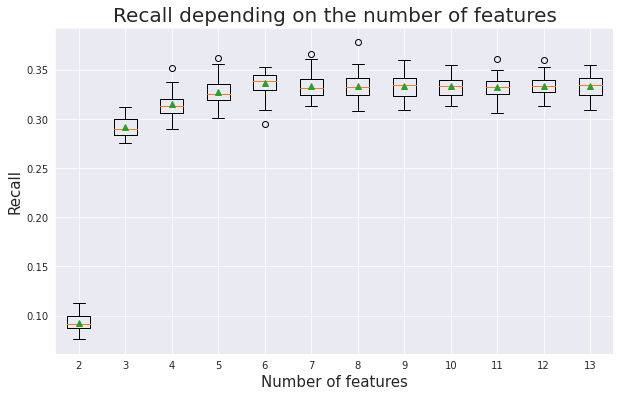

In [ ]:
# Deserialize the results of the RFE
results_rfe_file = open('/content/drive/MyDrive/BigData/results_rfe_pickle','rb')
results = pickle.load(results_rfe_file)
results_rfe_file.close()

names_rfe_file = open('/content/drive/MyDrive/BigData/names_rfe_file_pickle', 'rb')
names = pickle.load(names_rfe_file)
names_rfe_file.close()

# Plot the results
plt.figure(figsize=(10,6))
plt.title('Recall depending on the number of features', fontsize=20)
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Number of features', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.show()

As we can see, the Recall score increases until the number of features reaches 6 and then becomes stable.

### RFECV

We now look at the features selected automatically by the RFECV.

In [ ]:
### WARNING: LONG TIME EXECUTION

selected_features = list()

for estimator in tqdm([DecisionTreeClassifier(random_state=42)]):
  rfe = RFECV(estimator=estimator, min_features_to_select=2, scoring='recall', n_jobs=-1)
  rfe.fit(X, y)
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      selected_features.append(X.columns[i])


# Serialize the features selected by the RFECV
selected_features_rfecv_file = open('/content/drive/MyDrive/BigData/selected_features_rfecv_pickle', 'wb')
pickle.dump(selected_features, selected_features_rfecv_file)
selected_features_rfecv_file.close()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"
100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


In [16]:
# Deserialize the features selected by the RFECV
selected_features_rfecv_file = open('/content/drive/MyDrive/BigData/selected_features_rfecv_pickle','rb')
selected_features = pickle.load(selected_features_rfecv_file)
selected_features_rfecv_file.close()

print("\nSELECTED FEATURES:")
for feature in selected_features:
  print("- ", feature)


SELECTED FEATURES:
-  Age
-  WaitingDays
-  PrevAppointments
-  PrevNoShowRatio
-  GenderCoded
-  NeighbourhoodCoded
-  AppointmentDayCoded


We note that the RFECV selects seven features, this number is consistent with the RFE results.

Futhermore, we note that three out of four of the features that we have introduced during the Feature Engineering Phase have been selected by the RFECV.

Since the results obtained with the RFE and RFECV are similar we decide to use the seven selected features to train the models.

## Dataset with selected features

We prepare the dataset with the selected features. Then, we create a copy with normalized features, using MinMaxScaler: we will use this copy with models that require normalized features.

In [17]:
X_train_sf = X_train[selected_features]
X_test_sf = X_test[selected_features]

scaler = MinMaxScaler()
X_train_sf_norm = scaler.fit_transform(X_train_sf.values)
X_test_sf_norm = scaler.fit_transform(X_test_sf.values)

For each model we perform hyperparameter tuning on the Hyperparameter Space previously defined. In particular, we use GridSearchCV for all the models except Random Forest. For the latter, we use RandomizedSearchCV since this allows us to try quite a few configurations in a reasonable amount of time.

During the search, taking into account the unbalanced nature of the dataset, we use a stratified cross validation to compare the different models. The score used for comparison is Recall.

In [ ]:
### WARNING: LONG TIME EXECUTION

for model_name in models.keys():
  estimator = models[model_name]()
  params = hyperparameters[model_name]
  need_norm = need_normalization[model_name]
  randomized = randomized_search[model_name]
  train_set = X_train_sf
  test_set = X_test_sf
  
  # Hyperparameter tuning
  if randomized:
    grid_search = RandomizedSearchCV(estimator = estimator, param_distributions=params, cv=3, scoring='recall', n_iter=150, random_state=42)
  else:
    grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
  if need_norm:
    train_set = X_train_sf_norm
    test_set = X_test_sf_norm
  grid_search.fit(train_set, y_train)

  # Training 
  model = models[model_name]()
  model.set_params(**grid_search.best_params_)
  model.fit(train_set, y_train)
 
  # Serialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_sf', 'wb')
  pickle.dump(model, model_file)
  model_file.close()

For each model, we print the results regarding both training and test set.

********** DecisionTreeClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.95      0.42      0.58     59099
     No_show       0.29      0.92      0.44     14950

    accuracy                           0.52     74049
   macro avg       0.62      0.67      0.51     74049
weighted avg       0.82      0.52      0.55     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472



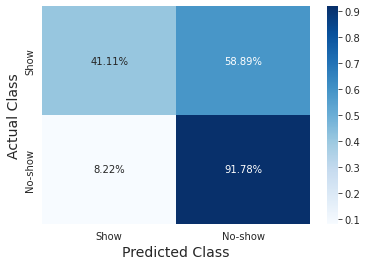






********** RandomForestClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.95      0.42      0.58     59099
     No_show       0.29      0.92      0.44     14950

    accuracy                           0.52     74049
   macro avg       0.62      0.67      0.51     74049
weighted avg       0.82      0.52      0.55     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.58     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472



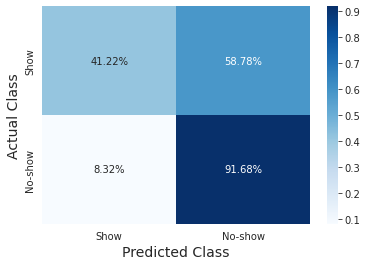






********** LogisticRegression **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.86      0.72      0.79     59099
     No_show       0.33      0.53      0.41     14950

    accuracy                           0.69     74049
   macro avg       0.59      0.63      0.60     74049
weighted avg       0.75      0.69      0.71     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.86      0.72      0.78     29108
     No_show       0.32      0.53      0.40      7364

    accuracy                           0.68     36472
   macro avg       0.59      0.62      0.59     36472
weighted avg       0.75      0.68      0.71     36472



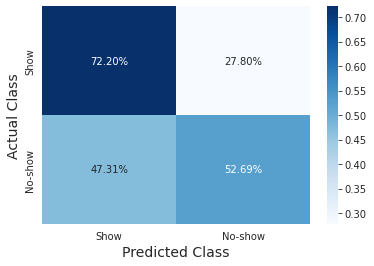






********** GaussianNB **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.81      0.91      0.86     59099
     No_show       0.34      0.17      0.23     14950

    accuracy                           0.76     74049
   macro avg       0.58      0.54      0.54     74049
weighted avg       0.72      0.76      0.73     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.81      0.91      0.86     29108
     No_show       0.33      0.17      0.22      7364

    accuracy                           0.76     36472
   macro avg       0.57      0.54      0.54     36472
weighted avg       0.72      0.76      0.73     36472



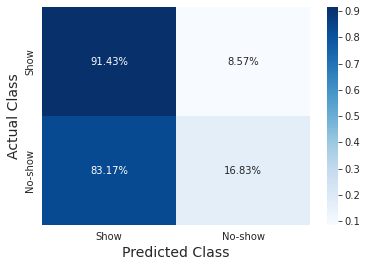






********** AdaBoostClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.81      0.98      0.89     59099
     No_show       0.49      0.08      0.14     14950

    accuracy                           0.80     74049
   macro avg       0.65      0.53      0.51     74049
weighted avg       0.74      0.80      0.73     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.81      0.98      0.88     29108
     No_show       0.48      0.08      0.13      7364

    accuracy                           0.80     36472
   macro avg       0.64      0.53      0.51     36472
weighted avg       0.74      0.80      0.73     36472



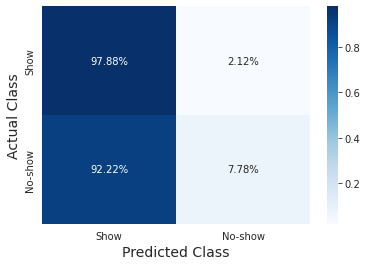

In [ ]:
for model_name in models.keys():
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_sf','rb')
  model = pickle.load(model_file)
  model_file.close()

  need_norm = need_normalization[model_name]
  train_set = X_train_sf
  test_set = X_test_sf

  if need_norm:
    train_set = X_train_sf_norm
    test_set = X_test_sf_norm

  # Evaluation
  train_prediction = model.predict(train_set)
  test_prediction = model.predict(test_set)

  print("**********", model_name, "**********")
  print("RESULTS ON TRAINING SET:")
  report_scores(y_train, train_prediction)
  print("RESULTS ON TEST SET:")
  report_scores(y_test, test_prediction)
  #print("\n\n\n")
  conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'])
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.show()
  print("\n\n\n\n")

In the following table we summarize the results obtained on the test set: for each model are reported the Precision and Recall for the No-show class and TP, FP, TN and FN rates.

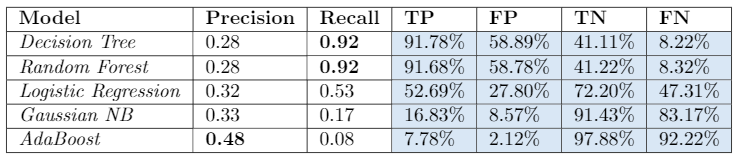


We note that:

- Decision Tree and Random Forest classifiers have very similar results. Both achieve very high recall for the No_show class, at the cost of lower precision (but still a bit higher than the precision of the Dummy classifier). Indeed, as we can see from the confusion matrix, we have a very low percentage of false negatives, but also quite a significant amount of false positives.

- Logistic Regression classifier has a bit higher precision with respect to the Decision Tree and Random Forest classifiers, but it also has a much lower recall.

- GaussianNB and AdaBoost classifiers both have very low recall and low precision for the No-show class and therefore are not suitable for this specific problem.

We plot the ROC curves of the different models to compare them and their AUC scores.

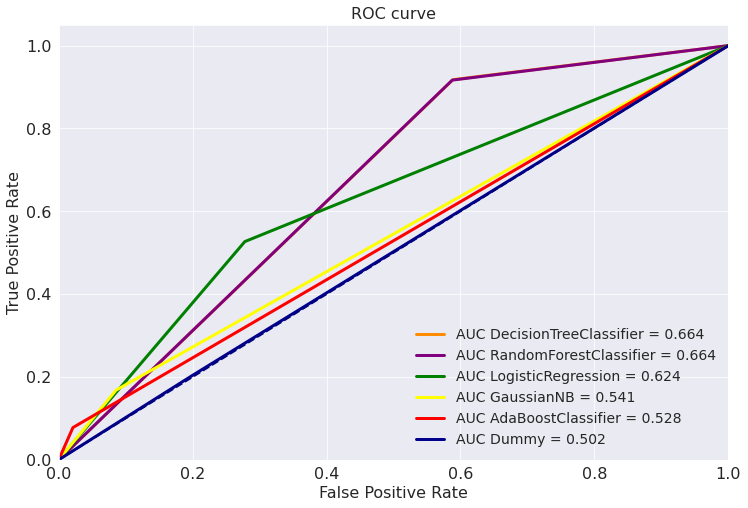

In [ ]:
plt.figure(figsize=(12,8))
for model_name in models.keys():
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_sf','rb')
  model = pickle.load(model_file)
  model_file.close()

  need_norm = need_normalization[model_name]
  train_set = X_train_sf
  test_set = X_test_sf

  if need_norm:
    train_set = X_train_sf_norm
    test_set = X_test_sf_norm

  # Evaluation
  train_prediction = model.predict(train_set)
  test_prediction = model.predict(test_set)
  
  fpr, tpr,_= roc_curve(y_test, test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC %s = %.3f' % (model_name, roc_auc)
  color = colors[model_name]
  # Plot the roc curve
  plt.plot(fpr, tpr, color=color, lw=3, label=label)

fpr, tpr,_= roc_curve(y_test, test_prediction_dummy)
roc_auc = auc(fpr, tpr)
label = 'AUC %s = %.3f' % ('Dummy', roc_auc)
color = 'DarkBlue'
# Plot the roc curve of the dummy classidier
plt.plot(fpr, tpr, color=color, lw=3, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

 Finally, we note that the Decision Tree and Random Forest classifiers have the highest AUC score. The Logistic Regression classifier has a bit worse AUC score compared to the previous two classifiers. Instead, GaussianNB and AdaBoost classifiers have an AUC score very close to the baseline.

Since the performances obtained with the Decision Tree and Random Forest classifiers are very similar, we choose as best model the Decision Tree classifier, being it simpler and also easier to interpret.

## Dataset with all features (original + derived)


In this section we repeat the same process as before, using the dataset that contains all the features. We do this to see if a reduced and selected number of features leads to comparable or better performance than using the dataset with all available features.

As before, we create the dataset and also a normalized version of it.

In [ ]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train.values)
X_test_norm = scaler.fit_transform(X_test.values)

We repeat the same process to select the best hyperparameters, training and evaluating the model.

In [ ]:
### WARNING: LONG TIME EXECUTION

for model_name in models.keys():
  estimator = models[model_name]()
  params = hyperparameters[model_name]
  need_norm = need_normalization[model_name]
  randomized = randomized_search[model_name]
  train_set = X_train
  test_set = X_test
  
  # Hyperparameter tuning
  if randomized:
    grid_search = RandomizedSearchCV(estimator = estimator, param_distributions=params, cv=3, scoring='recall', n_iter=150, random_state=42)
  else:
    grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
  if need_norm:
    train_set = X_train_norm
    test_set = X_test_norm
  grid_search.fit(train_set, y_train)

  # Training 
  model = models[model_name]()
  model.set_params(**grid_search.best_params_)
  model.fit(train_set, y_train)

  # Serialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_all', 'wb')
  pickle.dump(model, model_file)
  model_file.close()

********** DecisionTreeClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.95      0.42      0.58     59099
     No_show       0.29      0.92      0.44     14950

    accuracy                           0.52     74049
   macro avg       0.62      0.67      0.51     74049
weighted avg       0.82      0.52      0.55     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472



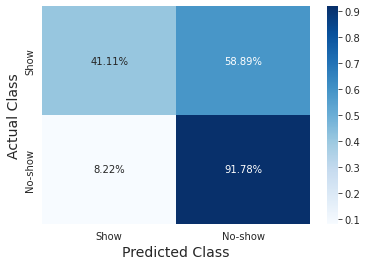






********** RandomForestClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.95      0.42      0.58     59099
     No_show       0.29      0.92      0.44     14950

    accuracy                           0.52     74049
   macro avg       0.62      0.67      0.51     74049
weighted avg       0.82      0.52      0.55     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.58     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472



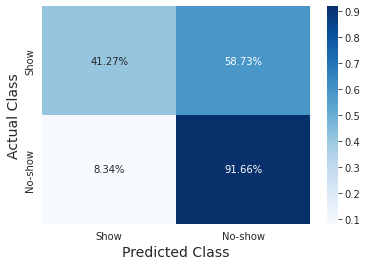






********** LogisticRegression **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.87      0.67      0.76     59099
     No_show       0.31      0.59      0.41     14950

    accuracy                           0.65     74049
   macro avg       0.59      0.63      0.58     74049
weighted avg       0.76      0.65      0.69     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.86      0.67      0.75     29108
     No_show       0.31      0.58      0.40      7364

    accuracy                           0.65     36472
   macro avg       0.59      0.63      0.58     36472
weighted avg       0.75      0.65      0.68     36472



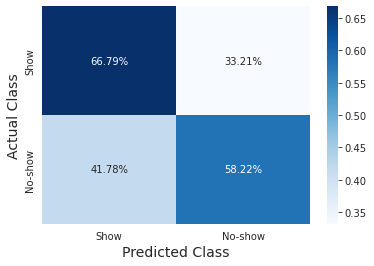






********** GaussianNB **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.82      0.88      0.85     59099
     No_show       0.33      0.25      0.28     14950

    accuracy                           0.75     74049
   macro avg       0.58      0.56      0.56     74049
weighted avg       0.72      0.75      0.73     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.82      0.87      0.85     29108
     No_show       0.33      0.24      0.28      7364

    accuracy                           0.75     36472
   macro avg       0.58      0.56      0.56     36472
weighted avg       0.72      0.75      0.73     36472



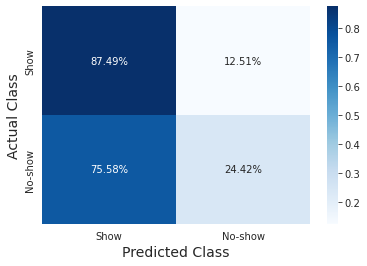






********** AdaBoostClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.81      0.98      0.89     59099
     No_show       0.50      0.07      0.13     14950

    accuracy                           0.80     74049
   macro avg       0.65      0.53      0.51     74049
weighted avg       0.75      0.80      0.73     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.81      0.98      0.89     29108
     No_show       0.50      0.07      0.13      7364

    accuracy                           0.80     36472
   macro avg       0.66      0.53      0.51     36472
weighted avg       0.75      0.80      0.73     36472



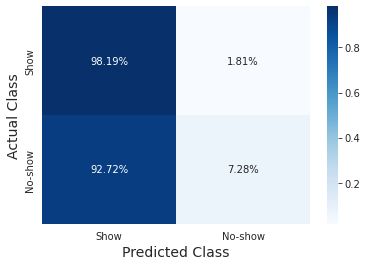

In [ ]:
for model_name in models.keys():
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_all','rb')
  model = pickle.load(model_file)
  model_file.close()

  need_norm = need_normalization[model_name]
  train_set = X_train
  test_set = X_test

  if need_norm:
    train_set = X_train_norm
    test_set = X_test_norm

  # Evaluation
  train_prediction = model.predict(train_set)
  test_prediction = model.predict(test_set)

  print("**********", model_name, "**********")
  print("RESULTS ON TRAINING SET:")
  report_scores(y_train, train_prediction)
  print("RESULTS ON TEST SET:")
  report_scores(y_test, test_prediction)
  #print("\n\n\n")
  conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'], )
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.show()
  print("\n\n\n\n")

In the following table we summarize the results obtained on the test set: for each model are reported the Precision and Recall for the No-show class and TP, FP, TN and FN rates.

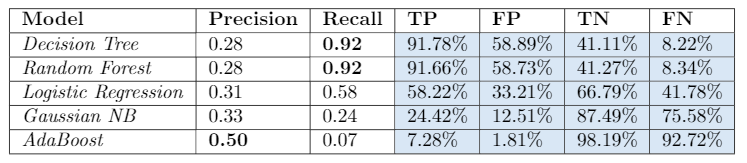

By repeating the analysis with the complete dataset we obtain very similar results to those obtained using only the selected features.

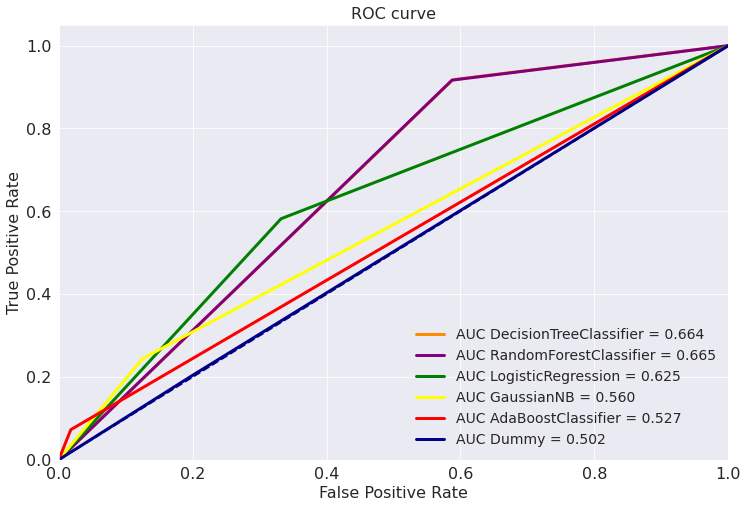

In [ ]:
plt.figure(figsize=(12,8))
for model_name in models.keys():
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_all','rb')
  model = pickle.load(model_file)
  model_file.close()

  need_norm = need_normalization[model_name]
  train_set = X_train
  test_set = X_test

  if need_norm:
    train_set = X_train_norm
    test_set = X_test_norm

  # Evaluation
  train_prediction = model.predict(train_set)
  test_prediction = model.predict(test_set)
  
  fpr, tpr,_= roc_curve(y_test, test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC %s = %.3f' % (model_name, roc_auc)
  color = colors[model_name]
  # Plot the roc curve
  plt.plot(fpr, tpr, color=color, lw=3, label=label)

fpr, tpr,_= roc_curve(y_test, test_prediction_dummy)
roc_auc = auc(fpr, tpr)
label = 'AUC %s = %.3f' % ('Dummy', roc_auc)
color = 'DarkBlue'
# Plot the roc curve of the dummy classidier
plt.plot(fpr, tpr, color=color, lw=3, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Also, we note that the AUC scores of each model are almost identical to the ones obtained using the previous dataset.

We can conclude that the feature extraction has been effective in selecting a small subset of meaningful features.

## Original Dataset

In this section we repeat the same process one last time, using the dataset that contains only the original attributes. We do this to test the goodness of the features that we have introduced in the Feature Engineering phase. In fact, we expect to obtain worse results with this dataset.

As before, we create the dataset and also a normalized version of it.

In [ ]:
X_train_original = X_train.drop(['PrevAppointments', 'PrevNoShowRatio', 'WaitingDays', 'AppointmentDayCoded'], axis=1)
X_test_original = X_test.drop(['PrevAppointments', 'PrevNoShowRatio', 'WaitingDays', 'AppointmentDayCoded'], axis=1)

# Create a normalized version of the dataset
scaler = MinMaxScaler()
X_train_original_norm = scaler.fit_transform(X_train_original.values)
X_test_original_norm = scaler.fit_transform(X_test_original.values)


Now we perform the hyperparameter tuning, model training and evaluation.

In [ ]:
### WARNING: LONG TIME EXECUTION

for model_name in models.keys():
  estimator = models[model_name]()
  params = hyperparameters[model_name]
  need_norm = need_normalization[model_name]
  randomized = randomized_search[model_name]
  train_set = X_train_original
  test_set =X_test_original
  
  # Hyperparameter tuning
  if randomized:
    grid_search = RandomizedSearchCV(estimator = estimator, param_distributions=params, cv=3, scoring='recall', n_iter=150, random_state=42)
  else:
    grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
  if need_norm:
    train_set = X_train_original_norm
    test_set = X_test_original_norm
  grid_search.fit(train_set, y_train)

  # Training 
  model = models[model_name]()
  model.set_params(**grid_search.best_params_)
  model.fit(train_set, y_train)

  # Serialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_original', 'wb')
  pickle.dump(model, model_file)
  model_file.close()


********** DecisionTreeClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.86      0.61      0.72     59099
     No_show       0.29      0.61      0.39     14950

    accuracy                           0.61     74049
   macro avg       0.57      0.61      0.55     74049
weighted avg       0.75      0.61      0.65     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.84      0.59      0.70     29108
     No_show       0.25      0.55      0.35      7364

    accuracy                           0.59     36472
   macro avg       0.55      0.57      0.52     36472
weighted avg       0.72      0.59      0.63     36472



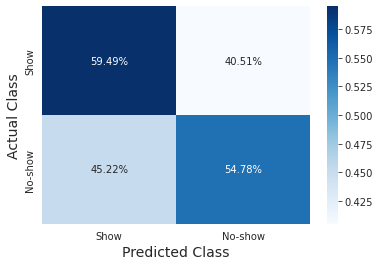






********** RandomForestClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.86      0.68      0.76     59099
     No_show       0.31      0.57      0.40     14950

    accuracy                           0.66     74049
   macro avg       0.59      0.63      0.58     74049
weighted avg       0.75      0.66      0.69     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.84      0.66      0.74     29108
     No_show       0.27      0.51      0.36      7364

    accuracy                           0.63     36472
   macro avg       0.56      0.58      0.55     36472
weighted avg       0.73      0.63      0.66     36472



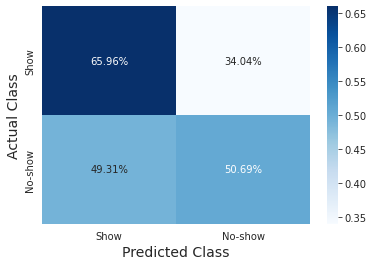






********** LogisticRegression **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.84      0.67      0.74     59099
     No_show       0.27      0.48      0.34     14950

    accuracy                           0.63     74049
   macro avg       0.55      0.57      0.54     74049
weighted avg       0.72      0.63      0.66     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.83      0.67      0.74     29108
     No_show       0.27      0.48      0.34      7364

    accuracy                           0.63     36472
   macro avg       0.55      0.57      0.54     36472
weighted avg       0.72      0.63      0.66     36472



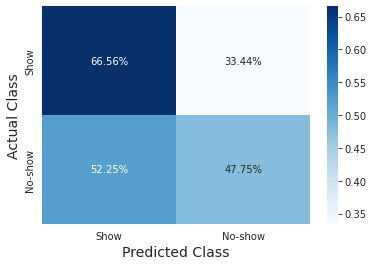






********** GaussianNB **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.80      0.98      0.88     59099
     No_show       0.34      0.04      0.07     14950

    accuracy                           0.79     74049
   macro avg       0.57      0.51      0.48     74049
weighted avg       0.71      0.79      0.72     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.80      0.98      0.88     29108
     No_show       0.35      0.05      0.08      7364

    accuracy                           0.79     36472
   macro avg       0.58      0.51      0.48     36472
weighted avg       0.71      0.79      0.72     36472



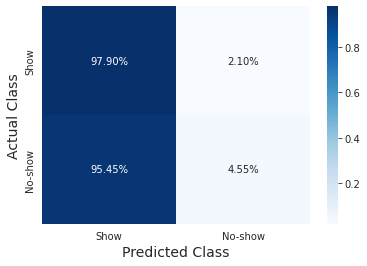






********** AdaBoostClassifier **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.80      1.00      0.89     59099
     No_show       1.00      0.00      0.00     14950

    accuracy                           0.80     74049
   macro avg       0.90      0.50      0.44     74049
weighted avg       0.84      0.80      0.71     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.80      1.00      0.89     29108
     No_show       0.33      0.00      0.00      7364

    accuracy                           0.80     36472
   macro avg       0.57      0.50      0.44     36472
weighted avg       0.70      0.80      0.71     36472



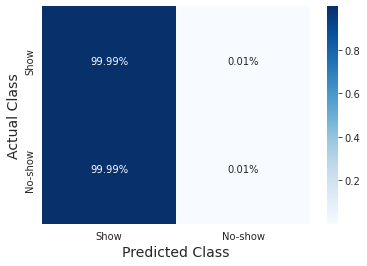

In [ ]:
for model_name in models.keys():
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_original','rb')
  model = pickle.load(model_file)
  model_file.close()

  need_norm = need_normalization[model_name]
  train_set = X_train_original
  test_set = X_test_original

  if need_norm:
    train_set = X_train_original_norm
    test_set = X_test_original_norm

  # Evaluation
  train_prediction = model.predict(train_set)
  test_prediction = model.predict(test_set)

  print("**********", model_name, "**********")
  print("RESULTS ON TRAINING SET:")
  report_scores(y_train, train_prediction)
  print("RESULTS ON TEST SET:")
  report_scores(y_test, test_prediction)
  #print("\n\n\n")
  conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'], )
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.show()
  print("\n\n\n\n")

In the following table we summarize the results obtained on the test set: for each model are reported the Precision and Recall for the No-show class and TP, FP, TN and FN rates.

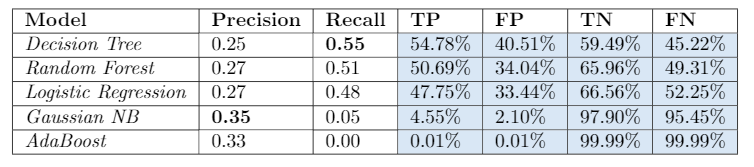

We see from the reported scores and the confusion matrixes that every tested model has a worse performance on this dataset, with respect to the previous datasets.

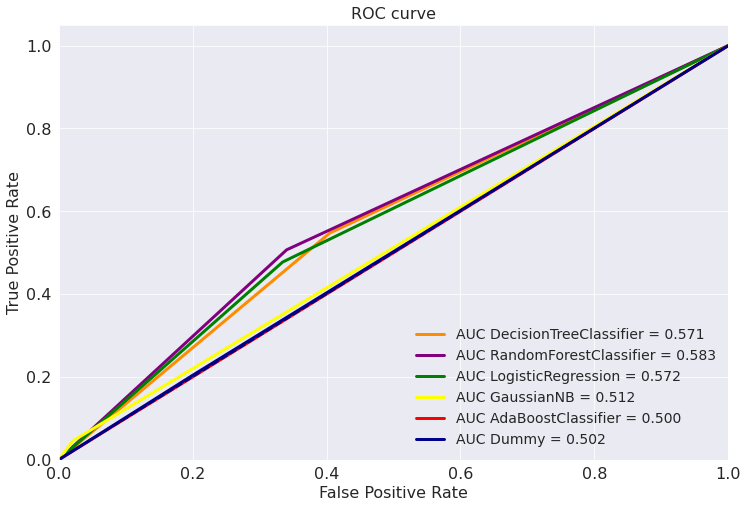

In [ ]:
plt.figure(figsize=(12,8))
for model_name in models.keys():
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_original','rb')
  model = pickle.load(model_file)
  model_file.close()

  need_norm = need_normalization[model_name]
  train_set = X_train_original
  test_set = X_test_original

  if need_norm:
    train_set = X_train_original_norm
    test_set = X_test_original_norm

  # Evaluation
  train_prediction = model.predict(train_set)
  test_prediction = model.predict(test_set)
  
  fpr, tpr,_= roc_curve(y_test, test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC %s = %.3f' % (model_name, roc_auc)
  color = colors[model_name]
  # Plot the roc curve
  plt.plot(fpr, tpr, color=color, lw=3, label=label)


fpr, tpr,_= roc_curve(y_test, test_prediction_dummy)
roc_auc = auc(fpr, tpr)
label = 'AUC %s = %.3f' % ('Dummy', roc_auc)
color = 'DarkBlue'
# Plot the roc curve of the dummy classidier
plt.plot(fpr, tpr, color=color, lw=3, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Also from the roc curves we can see a general worsening: all the AUC scores are lower than those obtained with the two previous datasets.

Thus, we can conclude that the features introduced during the Feature Engineering phase are significant since they lead to an increase in model performance.

## Best model and dataset

In conclusion, the best results have been obtained considering the seven features selected by the feature selection process and the best models turned out to be Random Forest and Decision Tree. Between the two, we prefer Decision Tree as it is a simpler and more explainable model.

<a id='balancing'></a>
# Testing different balancing techniques

Finally, we decide to apply different balancing techniques to the dataset with the selected features, since this dataset is the one on which we obtained the best performances, with the aim to investigate if it is possible to achieve even better performances.

We will try different models:
-   Decision Tree classifier, since is the best performing model. 
-   GaussianNB and AdaBoost classifiers: since these models do not have the option "class_weight = balanced", we think that they could benefit more from being trained on a balanced dataset.

### Oversampling with SMOTE

First of all, we try to oversample the dataset using the SMOTE algorithm.

In [38]:
ros = SMOTE(random_state=42)
X_train_smote, y_train_smote = ros.fit_resample(X_train_sf, y_train)

We perform hyperparameter tuning, model training and evaluation for all the three models.

In [ ]:
### WARNING: LONG TIME EXECUTION

for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  estimator = models[model_name]()
  params = hyperparameters[model_name]
  
  # Hyperparameter tuning
  grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
  grid_search.fit(X_train_smote, y_train_smote)

  # Training
  model = models[model_name]()
  model.set_params(**grid_search.best_params_)
  model.fit(X_train_smote, y_train_smote)

  # Serialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_smote', 'wb')
  pickle.dump(model, model_file)
  model_file.close()

********* DecisionTreeClassifier *********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.83      0.42      0.56     59099
     No_show       0.61      0.91      0.73     59099

    accuracy                           0.67    118198
   macro avg       0.72      0.67      0.65    118198
weighted avg       0.72      0.67      0.65    118198

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472







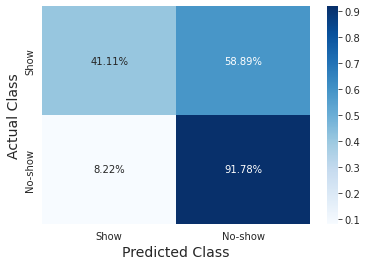






********* GaussianNB *********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.65      0.23      0.34     59099
     No_show       0.53      0.88      0.66     59099

    accuracy                           0.55    118198
   macro avg       0.59      0.55      0.50    118198
weighted avg       0.59      0.55      0.50    118198

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.86      0.23      0.36     29108
     No_show       0.22      0.85      0.35      7364

    accuracy                           0.35     36472
   macro avg       0.54      0.54      0.35     36472
weighted avg       0.73      0.35      0.36     36472







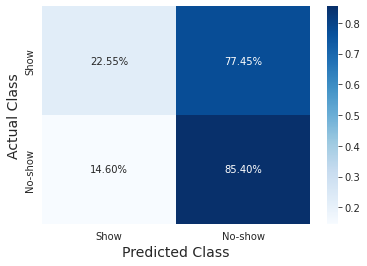






********* AdaBoostClassifier *********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.83      0.42      0.56     59099
     No_show       0.61      0.91      0.73     59099

    accuracy                           0.67    118198
   macro avg       0.72      0.67      0.65    118198
weighted avg       0.72      0.67      0.65    118198

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472







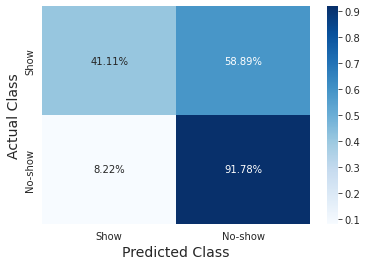

In [39]:
for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_smote','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  train_prediction = model.predict(X_train_smote)
  test_prediction = model.predict(X_test_sf)

  print("*********", model_name, "*********")
  print("RESULTS ON TRAINING SET:")
  report_scores(y_train_smote, train_prediction)
  print("RESULTS ON TEST SET:")
  report_scores(y_test, test_prediction)
  print("\n\n\n")
  conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'], )
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.show()
  print("\n\n\n\n")

In the following table we compare the results obtained without rebalancing the dataset with the ones obtained with the rebalanced dataset.

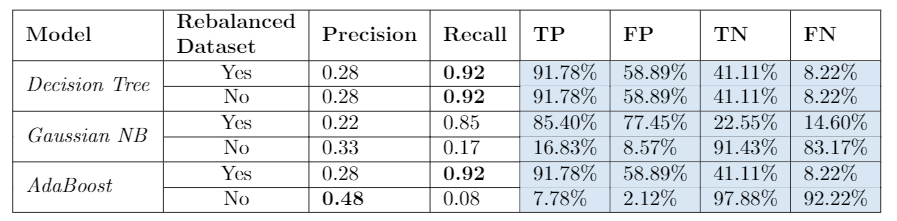

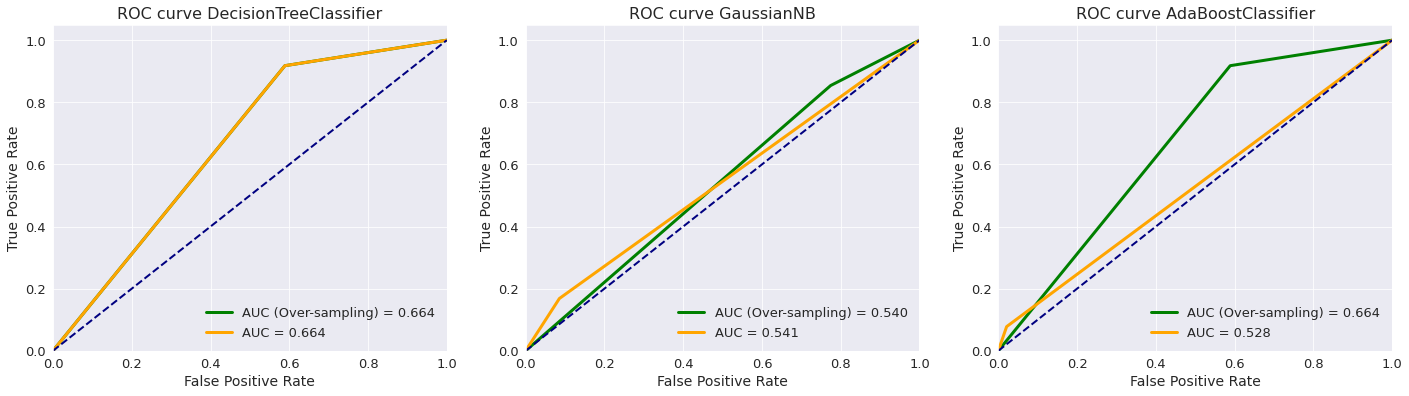

In [41]:
plt.figure(figsize=(24,6))
i=1
for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_smote','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  test_prediction = model.predict(X_test_sf)

  #Deserialize model selected features
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_sf','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  old_test_prediction = model.predict(X_test_sf)

  #ROC curve for rebalanced dataset
  fpr, tpr,_= roc_curve(y_test, test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC %s = %.3f' % ("(Over-sampling)", roc_auc)
  plt.subplot(1, 3, i)
  # Plot the roc curve
  plt.plot(fpr, tpr, color='Green', lw=3, label=label)

  #ROC curve for selected features dataset
  fpr, tpr,_= roc_curve(y_test, old_test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC = %.3f' % (roc_auc)
  # Plot the roc curve
  plt.plot(fpr, tpr, color='Orange', lw=3, label=label)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title("ROC curve " + model_name, fontsize=16)
  plt.legend(loc="lower right", fontsize=13, frameon=False)
  plt.tick_params(axis='both', which='major', labelsize=13)

  i += 1

plt.show()

We note that by oversampling the training set the performance of the Decision Tree classifier remains the same. This could be due to the fact that during the training we assigned different weights to the two classes according to their ratio. 

Instead, we note an increase in performance in the other two models. In particular, the AdaBoost classifier reaches the performance of the Decision Tree classifier.

### Undersampling

Now, we try to undersample the dataset using random under-sampling.

In [42]:
rus = RandomUnderSampler(random_state=42)

X_train_under, y_train_under = rus.fit_resample(X_train_sf, y_train)

In [ ]:
### WARNING: LONG TIME EXECUTION

for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  estimator = models[model_name]()
  params = hyperparameters[model_name]
  
  # Hyperparameter tuning
  grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
  grid_search.fit(X_train_under, y_train_under)

  # Training 
  model = models[model_name]()
  model.set_params(**grid_search.best_params_)
  model.fit(X_train_under, y_train_under)

  # Serialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_under', 'wb')
  pickle.dump(model, model_file)
  model_file.close()

*** DecisionTreeClassifier ***
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.84      0.42      0.56     14950
     No_show       0.61      0.92      0.74     14950

    accuracy                           0.67     29900
   macro avg       0.73      0.67      0.65     29900
weighted avg       0.73      0.67      0.65     29900

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472







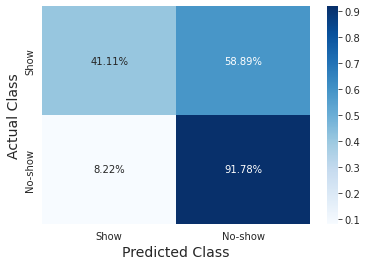






*** GaussianNB ***
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.63      0.31      0.41     14950
     No_show       0.54      0.82      0.65     14950

    accuracy                           0.56     29900
   macro avg       0.59      0.56      0.53     29900
weighted avg       0.59      0.56      0.53     29900

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.87      0.31      0.45     29108
     No_show       0.23      0.82      0.36      7364

    accuracy                           0.41     36472
   macro avg       0.55      0.56      0.41     36472
weighted avg       0.74      0.41      0.43     36472







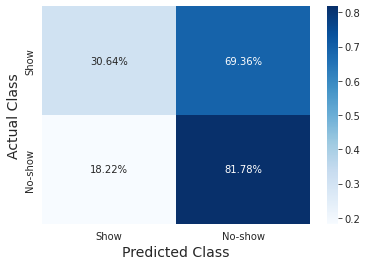






*** AdaBoostClassifier ***
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.84      0.42      0.56     14950
     No_show       0.61      0.92      0.74     14950

    accuracy                           0.67     29900
   macro avg       0.73      0.67      0.65     29900
weighted avg       0.73      0.67      0.65     29900

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472







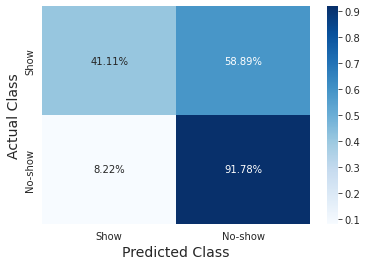

In [43]:
for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_under','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  train_prediction = model.predict(X_train_under)
  test_prediction = model.predict(X_test_sf)

  print("***", model_name, "***")
  print("RESULTS ON TRAINING SET:")
  report_scores(y_train_under, train_prediction)
  print("RESULTS ON TEST SET:")
  report_scores(y_test, test_prediction)
  print("\n\n\n")

  conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'], )
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.show()
  print("\n\n\n\n")

In the following tabale we compare the results obtained without rebalancing the dataset with the ones obtained with the rebalanced dataset.

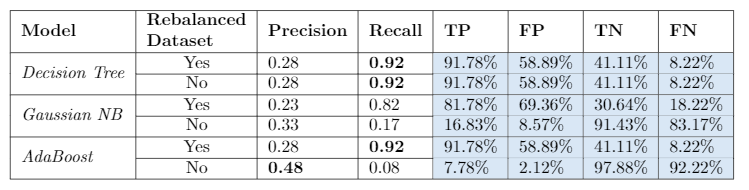

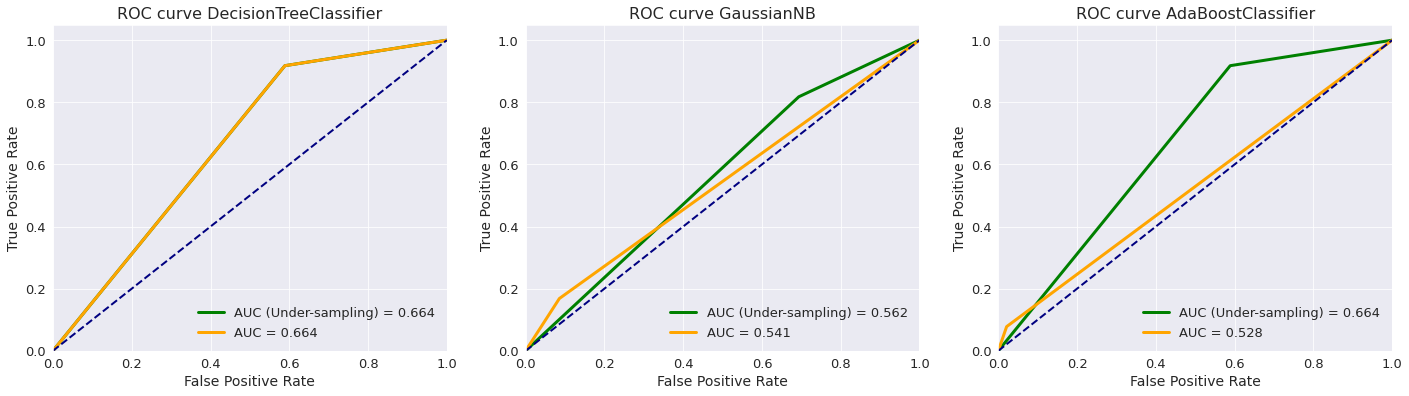

In [44]:
plt.figure(figsize=(24,6))
i=1
for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_under','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  test_prediction = model.predict(X_test_sf)

  #Deserialize model selected features
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_sf','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  old_test_prediction = model.predict(X_test_sf)

  #ROC curve for rebalanced dataset
  fpr, tpr,_= roc_curve(y_test, test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC %s = %.3f' % ("(Under-sampling)", roc_auc)
  plt.subplot(1, 3, i)
  # Plot the roc curve
  plt.plot(fpr, tpr, color='Green', lw=3, label=label)

  #ROC curve for selected features dataset
  fpr, tpr,_= roc_curve(y_test, old_test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC = %.3f' % (roc_auc)
  # Plot the roc curve
  plt.plot(fpr, tpr, color='Orange', lw=3, label=label)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title("ROC curve " + model_name, fontsize=16)
  plt.legend(loc="lower right", fontsize=13, frameon=False)
  plt.tick_params(axis='both', which='major', labelsize=13)

  i += 1

plt.show()

By performing undersampling we obtained very similar results to the ones obtained by oversampling with SMOTE.

### Combination of Oversampling and Undersampling

Finally, we use a combination of under-sampling and over-sampling. In particular, we apply the SMOTETomek algorithm which is a technique that combines over- and under-sampling using SMOTE and Tomek links.

In [45]:
ous = SMOTETomek(random_state=42)
X_train_over_under, y_train_over_under = ous.fit_resample(X_train_sf, y_train)

In [ ]:
### WARNING: LONG TIME EXECUTION

for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  estimator = models[model_name]()
  params = hyperparameters[model_name]
  
  # Hyperparameter tuning
  grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
  grid_search.fit(X_train_over_under, y_train_over_under)

  # Training 
  model = models[model_name]()
  model.set_params(**grid_search.best_params_)
  model.fit(X_train_over_under, y_train_over_under)

  # Serialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_over_under', 'wb')
  pickle.dump(model, model_file)
  model_file.close()

*** DecisionTreeClassifier ***
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.83      0.43      0.56     57837
     No_show       0.61      0.92      0.74     57837

    accuracy                           0.67    115674
   macro avg       0.72      0.67      0.65    115674
weighted avg       0.72      0.67      0.65    115674

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472







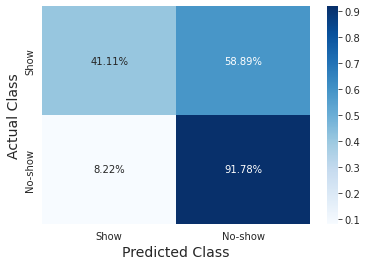






*** GaussianNB ***
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.66      0.23      0.34     57837
     No_show       0.53      0.88      0.66     57837

    accuracy                           0.56    115674
   macro avg       0.59      0.56      0.50    115674
weighted avg       0.59      0.56      0.50    115674

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.86      0.23      0.36     29108
     No_show       0.22      0.85      0.35      7364

    accuracy                           0.36     36472
   macro avg       0.54      0.54      0.36     36472
weighted avg       0.73      0.36      0.36     36472







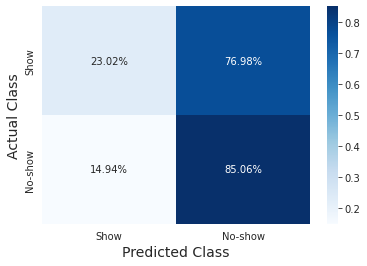






*** AdaBoostClassifier ***
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.83      0.43      0.56     57837
     No_show       0.61      0.92      0.74     57837

    accuracy                           0.67    115674
   macro avg       0.72      0.67      0.65    115674
weighted avg       0.72      0.67      0.65    115674

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.95      0.41      0.57     29108
     No_show       0.28      0.92      0.43      7364

    accuracy                           0.51     36472
   macro avg       0.62      0.66      0.50     36472
weighted avg       0.82      0.51      0.55     36472







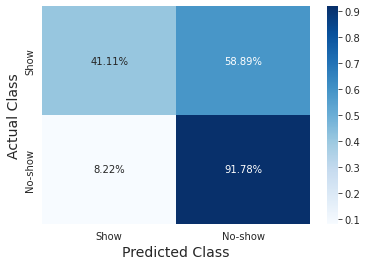

In [46]:
for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_over_under','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  train_prediction = model.predict(X_train_over_under)
  test_prediction = model.predict(X_test_sf)

  print("***", model_name, "***")
  print("RESULTS ON TRAINING SET:")
  report_scores(y_train_over_under, train_prediction)
  print("RESULTS ON TEST SET:")
  report_scores(y_test, test_prediction)
  print("\n\n\n")

  conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'], )
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.show()
  print("\n\n\n\n")

In the following tabale we compare the results obtained without rebalancing the dataset with the ones obtained with the rebalanced dataset.

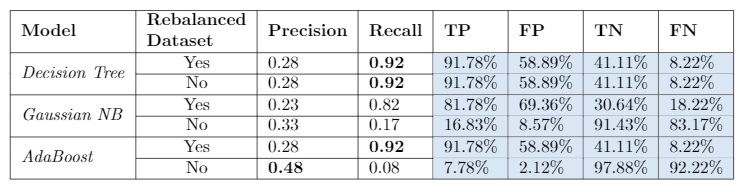

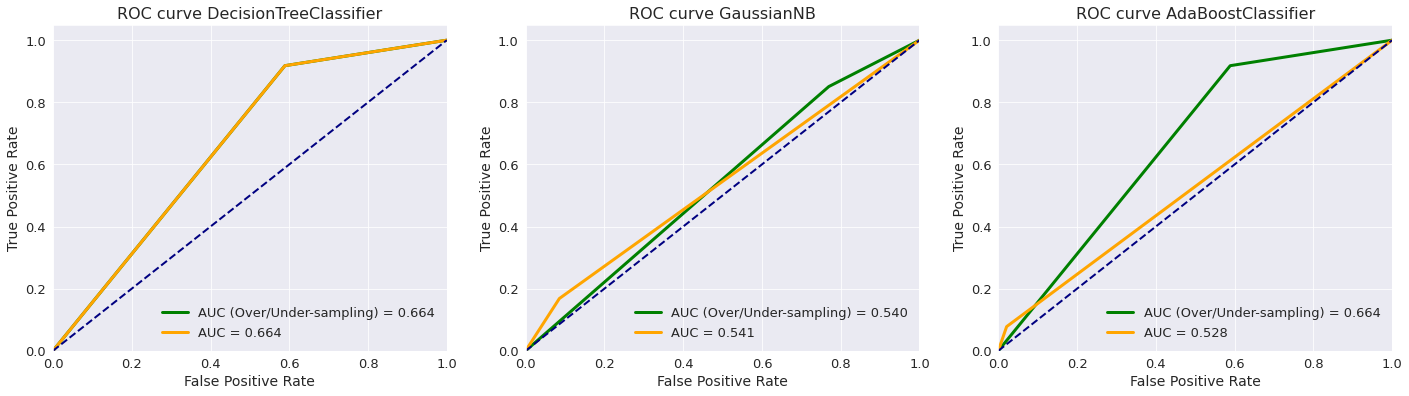

In [47]:
plt.figure(figsize=(24,6))
i=1
for model_name in ['DecisionTreeClassifier', 'GaussianNB', 'AdaBoostClassifier']:
  #Deserialize model
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_over_under','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  test_prediction = model.predict(X_test_sf)

  #Deserialize model selected features
  model_file = open('/content/drive/MyDrive/BigData/' + model_name + '_sf','rb')
  model = pickle.load(model_file)
  model_file.close()

  # Evaluation
  old_test_prediction = model.predict(X_test_sf)

  #ROC curve for rebalanced dataset
  fpr, tpr,_= roc_curve(y_test, test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC %s = %.3f' % ("(Over/Under-sampling)", roc_auc)
  color = colors[model_name]
  plt.subplot(1, 3, i)
  # Plot the roc curve
  plt.plot(fpr, tpr, color='Green', lw=3, label=label)

  #ROC curve for selected features dataset
  fpr, tpr,_= roc_curve(y_test, old_test_prediction)
  roc_auc = auc(fpr, tpr)
  label = 'AUC = %.3f' % (roc_auc)
  # Plot the roc curve
  plt.plot(fpr, tpr, color='Orange', lw=3, label=label)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title("ROC curve " + model_name, fontsize=16)
  plt.legend(loc="lower right", fontsize=13, frameon=False)
  plt.tick_params(axis='both', which='major', labelsize=13)

  i += 1

plt.show()

Again, we obtained very similar results to the ones obtained before.

<a id='conclusions'></a>
# Conclusions

In conclusion, by performing feature selection we identified a small but meaningful subset of features (*Age*, *WaitingDays*, *PrevAppointments*, *PrevNoShowRatio*, *GenderCoded*, *NeighbourhoodCoded*, *AppointmentDayCoded*).

By training and comparing different models on the reduced dataset we identified the Decision Tree classifier as the best model. On this model we were able to achieve high recall for the No-show class, however the precision score is quite low. In any case, also the other models do not have high precision (and they also have much lower recall).

In the end, we also tried to rebalance the training set with different techniques, however this process did not lead to a better performing model with respect to the Decision Tree classifier.

Perhaps, better results could be obtained if we had some more information such as: hour of the appointment, distance from the hospital, appointment type.
Moreover, if data had been collected over a  longer time period, it would better reflect time-dependent changes.

<a id='example'></a>
# Example of Classification

As a final test we try to classify three records choosen from the test set.

In [ ]:
#Deserialize model
model_file = open('/content/drive/MyDrive/BigData/DecisionTreeClassifier_sf','rb')
model = pickle.load(model_file)
model_file.close()

sample_records_pos = [233, 62402, 37908]

sample_test = X_test_sf.loc[sample_records_pos]
sample_y = y_test.loc[sample_records_pos]

sample_prediction = model.predict(sample_test)

for i in [0,1,2]:
  print(sample_test.loc[sample_records_pos[i]].to_string())
  print("ACTUAL CLASS: " + str(sample_y.loc[sample_records_pos[i]]))
  print("PREDICTED CLASS: " + str(sample_prediction[i]))
  print("\n\n")

Age                    36.0
WaitingDays            51.0
PrevAppointments        0.0
PrevNoShowRatio         0.0
GenderCoded             0.0
NeighbourhoodCoded     42.0
AppointmentDayCoded     0.0
ACTUAL CLASS: 1
PREDICTED CLASS: 1



Age                     1.0
WaitingDays            41.0
PrevAppointments        0.0
PrevNoShowRatio         0.0
GenderCoded             0.0
NeighbourhoodCoded     30.0
AppointmentDayCoded     1.0
ACTUAL CLASS: 1
PREDICTED CLASS: 1



Age                    76.0
WaitingDays             0.0
PrevAppointments        2.0
PrevNoShowRatio         0.0
GenderCoded             0.0
NeighbourhoodCoded     68.0
AppointmentDayCoded     5.0
ACTUAL CLASS: 0
PREDICTED CLASS: 0





For all the three records the model predictions are correct.

# Save the Notebook

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="bda-project-part-2")